In [12]:
x = read("catkira/1876954_7680KSPS_srsRAN_Project_gnb_short.sigmf-data"); @show length(x);

length(x) = 8802176


In [29]:
𝑓ₛ = 7.68e6

# This should be the nominal RF frequency of the subcarrier that we use as DC for demodulation
# (used for NR phase compensation)
f_dc = 187695e9

# these are in units of samples and depend on 𝑓ₛ
Tu = 512
Ncp = div(144, 4)
Ncpl = div(144 + 16, 4)

40

In [30]:
# phase correction to apply to symbols 0, 1, 2, 3, 4, 5, 6 in a 0.5 ms interval
p₀ = (f_dc .* (0:6) .* (Tu + Ncp)) / 𝑓ₛ
p₁ = p₀ .% 1
phase_corr = exp.(1im * 2 * π * p₁);

In [31]:
cfo = 18.88  # Hz
ϕ₀ = -2.97  # radians
sfo = -3.2e-6  # parts per one
sto_fine = 12.4e-9  # seconds

1.24e-8

In [32]:
# Amplitude adjustment to get symbols of unity amplitude
x = (x[1:2:end] + im * x[2:2:end]) / 2^31 * 24.7; @show x[1,:];

x[1, :] = ComplexF64[0.0 + 1.8402934074401855e-6im]


In [35]:
# Correct for CFO and phase offset
x .*= exp.(-1im * (2 * π * cfo/𝑓ₛ * (0:length(x)-1) .+ ϕ₀));

In [126]:
# Pseudo-random sequence
function c_seq(init, length)
    crop = 1600
    x₁ = zeros(UInt8, crop + length)
    x₂ = zeros(UInt8, crop + length)
    x₂[1] = 1

    for j in 1:31
        x₂[j + 1] = (init >> j) & 1
    end

    for j in 1:(length - 31)
        # x1[j + 31] = x1[j + 3] ⊻ x1[j]
        # x₂[j + 31] = x₂[j + 3] ⊻ x₂[j + 2] ⊻ x₂[j + 1] ⊻ x₂[j]
        x₁[j + 31] = x₁[j + 3] ^ x₁[j]
        x₂[j + 31] = x₂[j + 3] ^ x₂[j + 2] ^ x₂[j + 1] ^ x₂[j]
    end

    # return x₁[crop+1:end] ⊻ x₂[crop+1:end]
    return x₁[crop+1:end] ^ x₂[crop+1:end]
end

c_seq (generic function with 1 method)

In [127]:
cp_corr = zeros(ComplexF64, round(Int, 𝑓ₛ * 0.4e-3))
corr_start = round(Int, 9.05e-3 * 𝑓ₛ)

for j in 1:length(cp_corr)
    y = x[corr_start + j:corr_start + j + Ncp + Tu - 1]
    cp_corr[j] = sum(y[1:Ncp] .* conj.(y[end-Ncp+1:end]))
end

t_corr = 1e3 * (collect(0:length(cp_corr)-1) .+ corr_start) / 𝑓ₛ;

In [128]:
using Plots

In [129]:
cp_corr_plot = abs.(cp_corr)*1e7; # Somethin is off
# cp_corr_plot = abs.(cp_corr); # Original Code

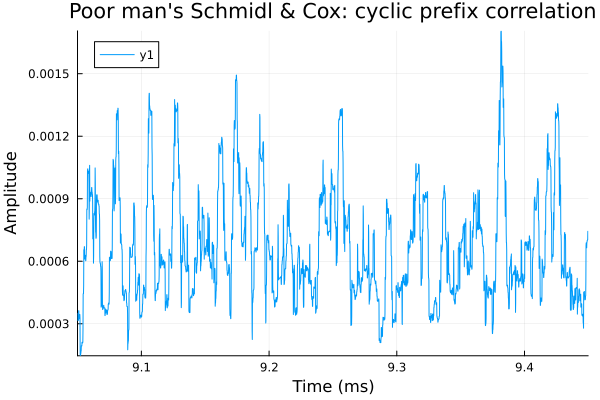

In [130]:
plot(t_corr, cp_corr_plot
    , xlabel="Time (ms)"
    , ylabel="Amplitude"
    , title="Poor man's Schmidl & Cox: cyclic prefix correlation"
    , xlim=(reduce((x,y) -> min.(x,y), t_corr),reduce((x,y) -> max.(x,y), t_corr))
    , ylim=(reduce((x,y) -> min.(x,y), cp_corr_plot),reduce((x,y) -> max.(x,y), cp_corr_plot))
)

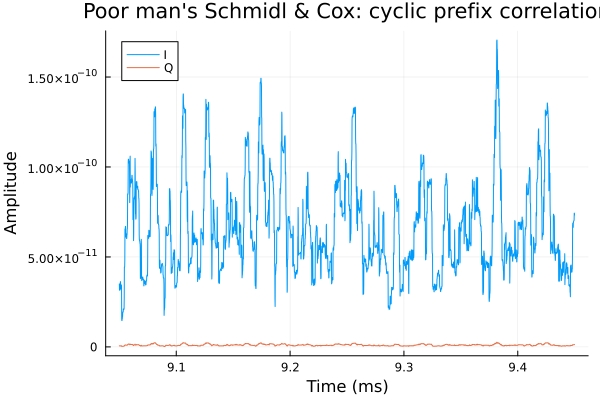

In [131]:
plot(t_corr, real.(cp_corr), label="I")
plot!(t_corr, imag.(cp_corr), label="Q")

xlabel!("Time (ms)")
ylabel!("Amplitude")
title!("Poor man's Schmidl & Cox: cyclic prefix correlation")

In [132]:
m₀ = argmax(abs.(cp_corr[1:1001]))
m₁ = argmax(abs.(cp_corr[1001:1501])) + 1000
m₂ = argmax(abs.(cp_corr[1501:2251])) + 1500
m₃ = argmax(abs.(cp_corr[2251:end])) + 2250

2549

In [133]:
CFO_est = -angle.(cp_corr[[m₀, m₁, m₂, m₃]]) / (2 * π) * (𝑓ₛ / Tu); @show CFO_est;

CFO_est = [-35.60260987405872, -36.52564422773533, -37.760000000000275, -35.39901961774862]


In [135]:
using FFTW

In [146]:
# Start demodulation at the middle of the cyclic prefix for maximum robustness to STO
a₀ = corr_start + m₀ + div(Ncp, 2)

f = fftshift(fft(x[a₀:a₀+Tu]));

In [147]:
# Correct for the 5G NR upconversion discontinuity
# This PSS is transmitted on symbol 2 mod 7
f .= f .* phase_corr[3];

In [218]:
# Correct for the fact that we're starting the demodulation at the middle of the cyclic prefix
p_t = exp.(1im * 2 * π * fftshift(fftfreq(Tu)) * Ncp / 2);

In [219]:
f .*= transpose(p_t);

In [220]:
pss_sc_sel = range(Int(Tu/2-120+56), Int(Tu/2-120+56+127))

192:319

In [229]:
all_sb_plot = plot(size(f,1) - div(Tu, 2), 10 * log10.(abs2.(f)), label="All subcarriers")
plot!(pss_sc_sel .- div(Tu, 2), 10 * log10.(abs2.(f[pss_sc_sel])), label="PSS subcarriers")

title!("PSS subcarrier power")
xlabel!("Subcarrier number (DC = 0)")
ylabel!("Power (dB)")

savefig(all_sb_plot,"images/all_sb_plot.png");

<img src=images/all_sb_plot.png width='' heigth='' > </img>

In [243]:
pss_sym_demod = f[pss_sc_sel];